In [1]:
import casadi
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm

In [2]:
a = 0.06
b = 0.06
c = 0.024
d = 0.06
e = 0.06
f = 0.012

K = 30

nx = 2
nu = 1
total = nx * (K + 1) + nu * K

Q = casadi.diag([1, 1])
Q_f = casadi.diag([1, 1])
R = casadi.diag([0.05])

x_lb = [0, 0]
x_ub = [np.inf, np.inf]
u_lb = [0]
u_ub = [1]

x_ref = casadi.DM([1, 1])
u_ref = casadi.DM([0])

In [3]:
def make_F():
    states = casadi.SX.sym("states", nx)
    ctrls = casadi.SX.sym("ctrls", nu)

    x = states[0]
    y = states[1]
    u = ctrls[0]

    x_next = (1 + a) * x - b * x * y - c * x * u
    y_next = (1 - d) * y + e * x * y - f * y * u

    states_next = casadi.vertcat(x_next, y_next)

    F = casadi.Function("F", [states, ctrls], [states_next], ["x", "u"], ["x_next"])
    return F

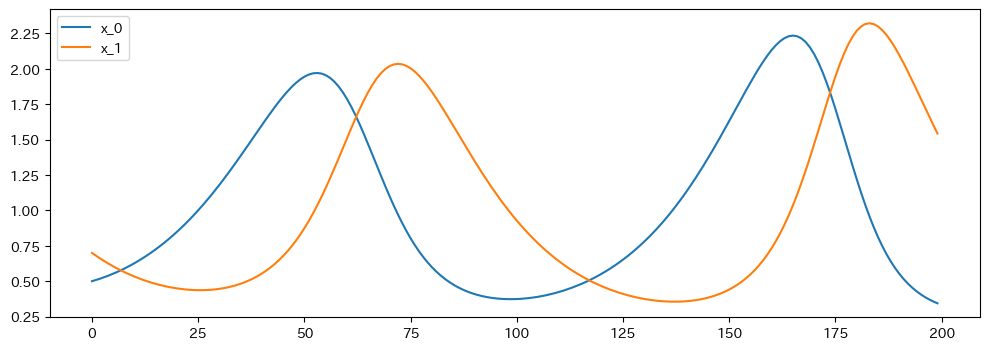

In [4]:
t_span = [0, 200]
t_eval = np.arange(*t_span)

x_init = casadi.DM([0.5, 0.7])

F = make_F()

X = [x_init]
x_current = x_init
for t in t_eval:
    x_current = F(x=x_current)["x_next"]
    X.append(x_current)

X.pop()
X = np.array(X).reshape(t_eval.size, nx)

plt.figure(figsize=(12, 4))

plt.subplot(1, 1, 1)
for k in range(nx):
    plt.plot(t_eval, X[:, k], label=f"x_{k}")
plt.legend()

plt.savefig("images/chap4_mpc_no_control.png")
plt.show()

In [5]:
def compute_stage_cost(x, u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff, x_diff) + casadi.dot(R@u_diff, u_diff)) / 2
    return cost

In [6]:
def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff, x_diff) / 2
    return cost

In [7]:
def make_nlp():
    F = make_F()

    X = [casadi.SX.sym(f"x_{k}", nx) for k in range(K + 1)]
    U = [casadi.SX.sym(f"u_{k}", nu) for k in range(K)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k], U[k])
        eq = X[k + 1] - F(x=X[k], u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {"print_time": False, "ipopt": {"print_level": 0}}
    nlp = {"x": casadi.vertcat(*X, *U), "f": J, "g": casadi.vertcat(*G)}
    S = casadi.nlpsol("S", "ipopt", nlp, option)
    return S

In [8]:
def compute_optimal_controll(S, x_init, x0):
    x_init = x_init.full().ravel().tolist()

    lbx = x_init + x_lb * K + u_lb * K
    ubx = x_init + x_ub * K + u_ub * K
    lbg = [0] * nx * K
    ubg = [0] * nx * K

    res = S(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, x0=x0)

    offset = nx * (K + 1)
    x0 = res["x"]
    u_opt = x0[offset: offset + nu]
    return u_opt, x0

In [11]:
S = make_nlp()

t_span = [0, 200]
t_eval = np.arange(*t_span, 1)

x_init = casadi.DM([0.5, 0.7])
x0 = casadi.DM.zeros(total)

F = make_F()

X = [x_init]
U = []

x_current = x_init
for t in t_eval:
    u_opt, x0 = compute_optimal_controll(S, x_current, x0)
    x_current = F(x=x_current, u=u_opt)["x_next"]
    X.append(x_current)
    U.append(u_opt)

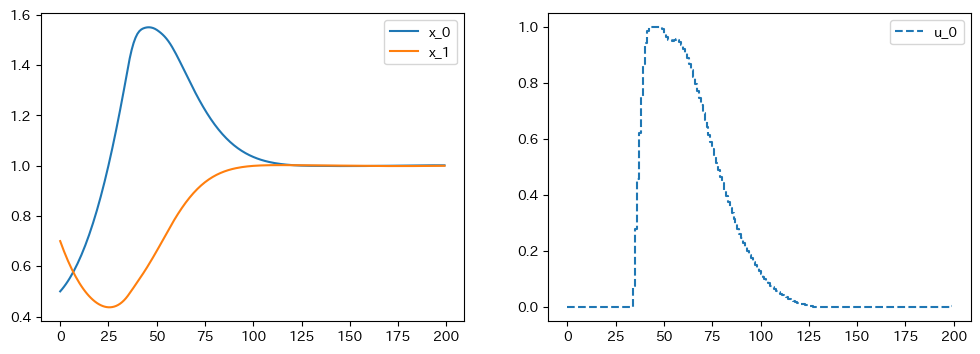

In [12]:
X.pop()
X = np.array(X).reshape(t_eval.size, nx)
U = np.array(U).reshape(t_eval.size, nu)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(nx):
    plt.plot(t_eval, X[:, k], label=f"x_{k}")
plt.legend()

plt.subplot(1, 2, 2)
for k in range(nu):
    plt.step(t_eval, U[:, k], linestyle="--", label=f"u_{k}")
plt.legend()

plt.savefig("images/chap4_mpc.png")
plt.show()